In [12]:
%matplotlib inline

from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
import re
import time
import math
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import collections
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import concurrent.futures
from tqdm.notebook import tqdm_notebook
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple, Dict
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict
import seaborn as sns

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
def get_soup_from_url(url: str, headers: Dict[str, str], page_number: int) -> BeautifulSoup:
    """
    Fetch the HTML content from a given URL with the specified headers and page number.

    Parameters:
        url (str): The base URL.
        headers (dict): The HTTP headers to be used for the request.
        page_number (int): The page number to fetch.

    Returns:
        BeautifulSoup: The parsed HTML content.
    """
    try:
        response = requests.get(url.format(page_number), headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup

    except requests.exceptions.RequestException as e:
        raise Exception("Error occurred while making the request:", e)

def find_number_of_jobs_and_pages(soup: BeautifulSoup) -> Tuple[int, int]:
    """
    Extract the number of jobs and calculate the number of pages from the given soup.

    Parameters:
        soup (BeautifulSoup): The parsed HTML content.

    Returns:
        Tuple[int, int]: Number of jobs and number of pages.
    """
    try:
        count_block = soup.find_all('span')
        tot_num_jobs = count_block[2].text
        array_tot_num_jobs = tot_num_jobs.split(' ')
        num_jobs = int(array_tot_num_jobs[-2].replace(',', ''))
        num_pages = num_jobs // 30

        return num_jobs, num_pages

    except (IndexError, ValueError, AttributeError) as e:
        raise Exception("Error occurred while finding the number of jobs:", e)

def process_job_desc_element(element: BeautifulSoup) -> List[str]:
    """
    Process the job description element and apply substitutions.

    Parameters:
        element (BeautifulSoup): The job description element.

    Returns:
        str: Processed job description.
    """
    job_desc = []
    for job_summary in element:
        job_desc.append(job_summary.get_text(strip=True))
    return job_desc

def fetch_and_process_page(url: str, headers: Dict[str, str], page_number: int) -> List[str]:
    """
    Fetch and process job desc from a given page number.

    Parameters:
        url (str): The base URL.
        headers (dict): The HTTP headers to be used for the request.
        page_number (int): The page number to fetch.

    Returns:
        List[str]: List of job desc for the current page.
    """
    soup = get_soup_from_url(url, headers, page_number)
    if soup:
        job_desc_elements = soup.find_all(class_='job-summary-full')
        job_desc_arr = [process_job_desc_element(element) for element in job_desc_elements]
        job_desc_arr = [','.join(inner_list) for inner_list in job_desc_arr]
        return job_desc_arr

    return []

def get_job_desc(url: str, headers: Dict[str, str], num_pages: int) -> List[str]:
    """
    Fetch and process job desc from multiple search pages with concurrency.

    Parameters:
        url (str): The base URL.
        headers (dict): The HTTP headers to be used for the request.
        num_pages (int): The number of search result pages.

    Returns:
        List[str]: List of all job desc.
    """
    job_desc_arr = []

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(fetch_and_process_page, url, headers, page) for page in range(1, num_pages + 1)]
        for future in tqdm_notebook(concurrent.futures.as_completed(futures), total=len(futures), desc="Fetching job desc", leave=True):
            job_desc_arr.extend(future.result())

    return job_desc_arr

def fetch_and_process_job_data(url: str, headers: Dict[str, str]) -> None:
    """
    Fetch and process job data, including job desc.

    Parameters:
        url (str): The base URL.
        headers (dict): The HTTP headers to be used for the request.
    """
    try:
        soup = get_soup_from_url(url, headers, "1")
        num_jobs, num_pages = find_number_of_jobs_and_pages(soup)
        if num_jobs is not None and num_pages is not None:
            print("Number of jobs:", num_jobs)
            print("Number of pages:", num_pages)

            # Add a delay between requests to avoid Too Many Requests error
            time.sleep(2)

            # job_desc_arr = get_job_desc(url, headers, num_pages)
            job_desc_arr = get_job_desc(url, headers, 5)
            print("Job desc:", job_desc_arr)
            return job_desc_arr
        else:
            print("Unable to find the number of jobs and pages.")

    except requests.exceptions.RequestException as e:
        print("An error occurred while fetching data:", e)

In [13]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}
url = "https://www.dice.com/jobs/q-machine%20learning%20engineer-limit-30-l-94158-radius-30-startPage-%7B%7D-limit-30-jobs"


# Call the function to fetch and process job data
job_desc_arr = fetch_and_process_job_data(url, headers)

Number of jobs: 383
Number of pages: 12


Fetching job desc:   0%|          | 0/5 [00:00<?, ?it/s]

Job desc: [',Greetings from E-Solutions Inc. Must be ready for assessment and 2 rounds interview . X1 Junior ML Engineer Location: NYC  (Remote from East Coast)  Start date: ASAP  Duration: Fulltime  Job Description As a backend ML engineer, you will sit on a product team developing AI, ML, and optimization products that are of strategic importance to the firm. You will partner with our product managers, researchers, and stakeholder teams to develop production grade model implementations and infrastructure t', ',ML Engineer Looking for a Machine Learning Engineer to support ML model development and training, ML operations, Data Pipelines (Data acquisition, cleanup), etc. This person should have experience building and operating production ML systems in production and be able to give examples. ML Data Pipelines, Cleanup Transformation, scale, etc. Required: Solid ML development experience. Solid experience with Model Development/Training and ML Operations. Solid experience with Data Pip

In [8]:
len(job_desc_arr)

100

In [9]:
def create_wordcloud_from_job_desc(job_desc_arr: List[str]) -> str:
    """
    Create a WordCloud from a list of job desc.

    Parameters:
        job_desc_arr (List[str]): List of job desc.

    Returns:
        str: Concatenated job desc as a single string.
    """
    if job_desc_arr is not None:
        # Convert all elements in the 'job_desc_arr' list to strings using list comprehension
        job_desc = [str(desc) for desc in job_desc_arr]

        # Concatenate all the text elements in the array into a single string
        text_data = ', '.join(job_desc)

        # Create a WordCloud object with NLTK-based tokenization
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

        # Display the word cloud using matplotlib
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

        return text_data
    else:
        print("No job desc found.")
        return ""

## Plot Words on a Word Map Without Subtracting Common Words

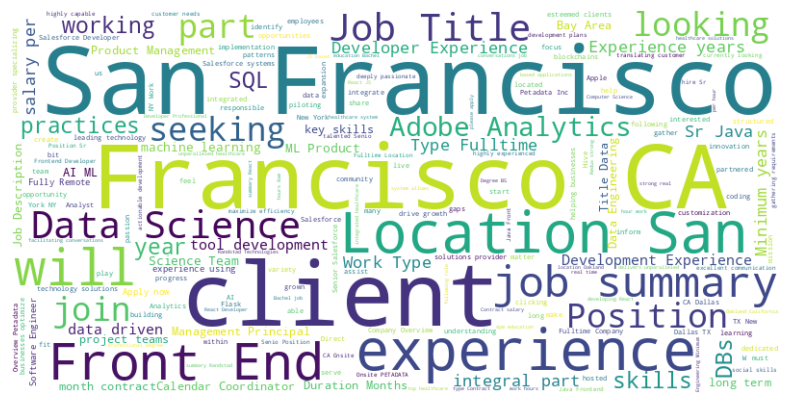

,Position: Senior Salesforce Developer  Experience: 12+ years  Location: San Francisco, CA / Dallas, TX / New York, NY  Work Type: Fulltime Company Overview  Petadata, Inc. is a leading technology solutions provider, specializing in Salesforce.com implementation and customization for the esteemed clients. We are dedicated to helping businesses optimize their Salesforce systems to drive growth and maximize efficiency. As part of our expansion, we are seeking a highly experienced and talented Senio, ,Position: Sr. Java Front End developer  Experience: 10+ years Work Type: Fulltime  Location: San Francisco, CA (Onsite) PETADATA is currently looking to hire Sr. Java Frontend Developer Positions for their team. This is a W-2, who is highly capable of and deeply passionate about understanding and translating customer needs into actionable development plans and strong technical and excellent communication and social skills, which can assist in gathering requirements and facilitating conversat

In [11]:
text_data = create_wordcloud_from_job_desc(job_desc_arr)
print(text_data)

In [14]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}
no_keyword_url = "https://www.dice.com/jobs/q--limit-30-l-94158-radius-30-startPage-%7B%7D-limit-30-jobs"



# Call the function to fetch and process job data
other_job_desc_arr = fetch_and_process_job_data(no_keyword_url, headers)

Number of jobs: 10307
Number of pages: 343


Fetching job desc:   0%|          | 0/5 [00:00<?, ?it/s]

Job desc: [',Position: AEM Developer (Senior) Experience: minimum 10+ Years Work Type: W-2 Job Location: San Francisco (CA) /New York (NY)/ Dallas (TX) PETADATA is hiring for the position of (multiple): AEM Developer for one of our clients. Roles & Responsibilities: The ideal candidate should communicate and work with teams as issues arise. Should analyze, design, develop, test, and deploy phases of development projects. Must have to develop and design web applications and software. Should follow relevant co', ',Position: Senior Salesforce Developer  Experience: 12+ years  Location: San Francisco, CA / Dallas, TX / New York, NY  Work Type: Fulltime Company Overview  Petadata, Inc. is a leading technology solutions provider, specializing in Salesforce.com implementation and customization for the esteemed clients. We are dedicated to helping businesses optimize their Salesforce systems to drive growth and maximize efficiency. As part of our expansion, we are seeking a highly experienced 

In [21]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tagged_tokens = nltk.pos_tag (tokens)
    relevant_tokens = []
    for token_tag in tagged_tokens:
        if token_tag[1]=="NN":
            relevant_tokens.append (token_tag[0])
    return relevant_tokens

vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df=0.1, stop_words='english')
X = vectorizer.fit_transform (job_desc_arr)
vectorizer.idf_.shape

indices = np.argsort (vectorizer.idf_)
top_n = 177
scores = vectorizer.idf_[indices[:top_n]]
features = vectorizer.get_feature_names_out()
top_features = [features[i] for i in indices[:top_n]]
feature_score = dict (zip (top_features, scores))
print (top_features)

other_vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df=0.1, stop_words='english')
X = other_vectorizer.fit_transform(other_job_desc_arr)
other_features = other_vectorizer.get_feature_names_out()
indices = np.argsort(other_vectorizer.idf_)
other_top_features = [other_features[i] for i in indices[:top_n]]
print (other_top_features)

['machine', 'engineer', 'team', 'ml', 'experience', 'job', 'learning', 'description', 'location', 'science', 'technology', 'position', 'product', 'development', 'model', 'duration', 'client', 'software', 'title', 'kforce', 'building', 'infrastructure', 'business', 'data', 'field', 'c', 'production', 'research', 'degree', 'design', 'computer', 'consulting', 'support', 'project', 'problem-solving', 'python', 'prediction', 'reimbursement', 'partner', 'stakeholder', 'training', 'troubleshooting', 'optimization', 'opportunity', 'use', 'role', 'nyc', 'algorithms', 'maintain', 'analysis', 'b', 'bachelor', 'backend', 'bigdata', 'c++', 'coding', 'core', 'date', 'debugging', 'monitoring', 'diagnosis', 'enhance', 'firm', 'grade', 'importance', 'include', 'information', 'internet', 'work', 'knowledge', 'machine-learning', 'engineering', '•']
['experience', 'job', 'location', 'position', 'development', 'francisco', 'software', 'type', 'company', 'team', 'description', 'contract', 'role', 'engineeri

In [22]:
# Convert the set to a list and get the first 1/3 elements
num_elements = len(other_top_features)
num_elements_to_keep = num_elements // 2
limited_elements_list = list(other_top_features)[:num_elements_to_keep]

# Convert the limited list back to a set
other_top_features = set(limited_elements_list)


data_specific_features = list(set(top_features) - set(other_top_features))

words_to_remove = ['intelligence', 'data', 'word', 'growth', 'eligibility', 'vision', 'resume', 'equity', \
                   'processing', 'right', 'copyright', 'minimum', 'hire', 'email', '©', 'consideration', 'today', \
                   'document', 'form', 'compliance', 'law', 'link', '%', 'way', 'end', 'variety','science', \
                   'machine', 'learning','experience','solutions','jobs','location','python','industry','remote', \
                   'description', 'complex', 'responsibilities','title','making','create','interested', 'create', \
                   'work','project','using','business','models','scientist','remote','years','highly', 'technology', \
                   'highly','?','innovative','deliver','problem','required','skills','new','ai','development','insights', \
                   'looking','duration','senior','experienced','opportunity','companies','job','provide','team','start', \
                   'benefits','hi','environment','engineers','techniques','(',')',':','.',',','role','preferred','3+', \
                   'share','-','working','language','bring','need','summary','best','salary','contract']
data_specific_features = [feature for feature in data_specific_features if feature not in words_to_remove]

data_specific_features

['maintain',
 'degree',
 'algorithms',
 'grade',
 'diagnosis',
 'building',
 'production',
 'coding',
 'model',
 '•',
 'include',
 'problem-solving',
 'information',
 'infrastructure',
 'field',
 'partner',
 'support',
 'bigdata',
 'optimization',
 'internet',
 'ml',
 'research',
 'backend',
 'debugging',
 'kforce',
 'troubleshooting',
 'monitoring',
 'importance',
 'knowledge',
 'c++',
 'training',
 'firm',
 'prediction',
 'analysis',
 'product',
 'use',
 'nyc',
 'machine-learning',
 'consulting',
 'core',
 'b',
 'bachelor',
 'enhance',
 'stakeholder',
 'computer',
 'c',
 'reimbursement',
 'date']

## All Jobs

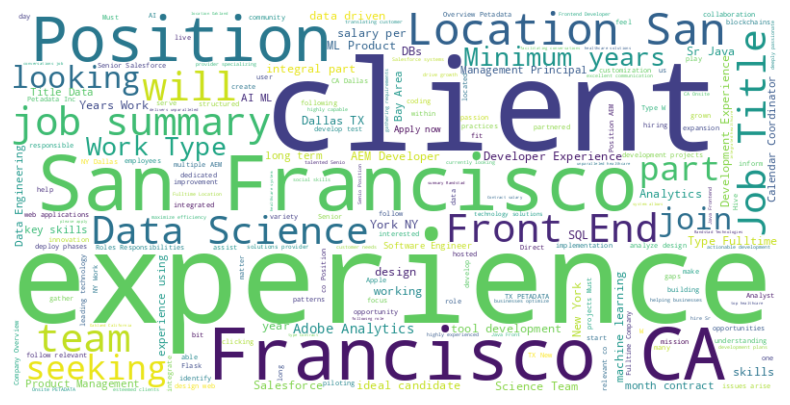

,Position: AEM Developer (Senior) Experience: minimum 10+ Years Work Type: W-2 Job Location: San Francisco (CA) /New York (NY)/ Dallas (TX) PETADATA is hiring for the position of (multiple): AEM Developer for one of our clients. Roles & Responsibilities: The ideal candidate should communicate and work with teams as issues arise. Should analyze, design, develop, test, and deploy phases of development projects. Must have to develop and design web applications and software. Should follow relevant co, ,Position: Senior Salesforce Developer  Experience: 12+ years  Location: San Francisco, CA / Dallas, TX / New York, NY  Work Type: Fulltime Company Overview  Petadata, Inc. is a leading technology solutions provider, specializing in Salesforce.com implementation and customization for the esteemed clients. We are dedicated to helping businesses optimize their Salesforce systems to drive growth and maximize efficiency. As part of our expansion, we are seeking a highly experienced and talented S

In [23]:
text_data = create_wordcloud_from_job_desc(other_job_desc_arr)
print(text_data)

## Top Features of Machine Learning Engineer Minus All Job Descriptions' Top Features

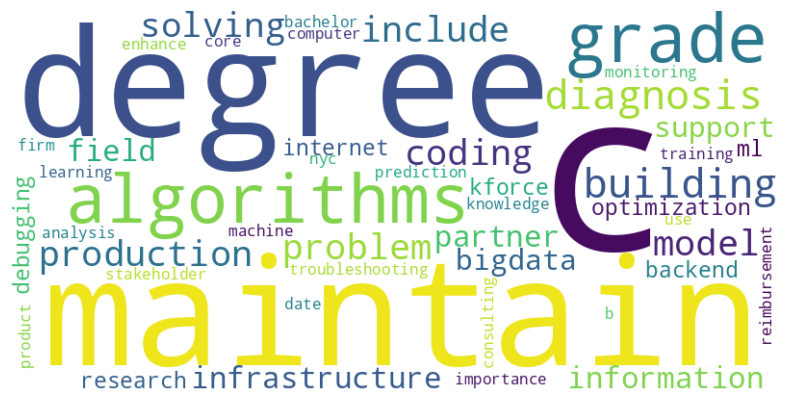

maintain, degree, algorithms, grade, diagnosis, building, production, coding, model, •, include, problem-solving, information, infrastructure, field, partner, support, bigdata, optimization, internet, ml, research, backend, debugging, kforce, troubleshooting, monitoring, importance, knowledge, c++, training, firm, prediction, analysis, product, use, nyc, machine-learning, consulting, core, b, bachelor, enhance, stakeholder, computer, c, reimbursement, date


In [24]:
text_data = create_wordcloud_from_job_desc(data_specific_features)
print(text_data)

In [25]:
job_desc_arr[:2]

[',Greetings from E-Solutions Inc. Must be ready for assessment and 2 rounds interview . X1 Junior ML Engineer Location: NYC  (Remote from East Coast)  Start date: ASAP  Duration: Fulltime  Job Description As a backend ML engineer, you will sit on a product team developing AI, ML, and optimization products that are of strategic importance to the firm. You will partner with our product managers, researchers, and stakeholder teams to develop production grade model implementations and infrastructure t',
 ',ML Engineer Looking for a Machine Learning Engineer to support ML model development and training, ML operations, Data Pipelines (Data acquisition, cleanup), etc. This person should have experience building and operating production ML systems in production and be able to give examples. ML Data Pipelines, Cleanup Transformation, scale, etc. Required: Solid ML development experience. Solid experience with Model Development/Training and ML Operations. Solid experience with Data Pipelines (D

In [27]:
len(other_top_features)

28

In [38]:
# Convert the job_desc_arr into a single long string
job_desc_string = ' '.join(job_desc_arr)
job_desc_string.split()[:3]

[',Greetings', 'from', 'E-Solutions']

In [37]:
filtered_words = [word for word in job_desc_words if word not in top_features]
filtered_words = [word for word in job_desc_words if word not in other_top_features]
filtered_words[:3]

[',Greetings', 'from', 'E-Solutions']

In [31]:
# Convert the job_desc_arr into a single long string
job_desc_string = ' '.join(job_desc_arr)

# Split the job_desc_string into words
job_desc_words = job_desc_string.split()

# Remove unwanted words that appear in other_top_features
filtered_words = [word for word in job_desc_words if word not in top_features]
filtered_words = [word for word in job_desc_words if word not in other_top_features]


,Greetings,from,E-Solutions,Inc.,Must,be,ready,for,assessment,and,2,rounds,interview,.,X1,Junior,ML,Engineer,Location:,NYC,(Remote,from,East,Coast),Start,date:,ASAP,Duration:,Fulltime,Job,Description,As,a,backend,ML,engineer,,you,will,sit,on,a,product,developing,AI,,ML,,and,optimization,products,that,are,of,strategic,importance,to,the,firm.,You,will,partner,with,our,product,managers,,researchers,,and,stakeholder,teams,to,develop,production,grade,model,implementations,and,infrastructure,t,,ML,Engineer,Looking,for,a,Machine,Learning,Engineer,to,support,ML,model,and,training,,ML,operations,,Data,Pipelines,(Data,acquisition,,cleanup),,etc.,This,person,should,have,building,and,operating,production,ML,systems,in,production,and,be,able,to,give,examples.,ML,Data,Pipelines,,Cleanup,Transformation,,scale,,etc.,Required:,Solid,ML,experience.,Solid,with,Model,Development/Training,and,ML,Operations.,Solid,with,Data,Pipelines,(Data,Acqui,,What,will,you,do?,Design,,build,and,optimize,scalable,data,sc

## All Job Descriptions Minus Top Features in Machine Learning Engineering Roles and All Job Roles

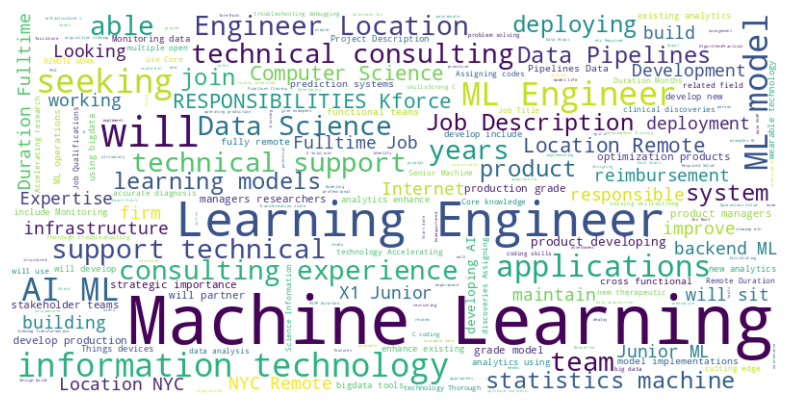

,Greetings, from, E-Solutions, Inc., Must, be, ready, for, assessment, and, 2, rounds, interview, ., X1, Junior, ML, Engineer, Location:, NYC, (Remote, from, East, Coast), Start, date:, ASAP, Duration:, Fulltime, Job, Description, As, a, backend, ML, engineer,, you, will, sit, on, a, product, developing, AI,, ML,, and, optimization, products, that, are, of, strategic, importance, to, the, firm., You, will, partner, with, our, product, managers,, researchers,, and, stakeholder, teams, to, develop, production, grade, model, implementations, and, infrastructure, t, ,ML, Engineer, Looking, for, a, Machine, Learning, Engineer, to, support, ML, model, and, training,, ML, operations,, Data, Pipelines, (Data, acquisition,, cleanup),, etc., This, person, should, have, building, and, operating, production, ML, systems, in, production, and, be, able, to, give, examples., ML, Data, Pipelines,, Cleanup, Transformation,, scale,, etc., Required:, Solid, ML, experience., Solid, with, Model, Developmen

In [36]:
text_data = create_wordcloud_from_job_desc(filtered_words)
print(text_data)